<a href="https://colab.research.google.com/github/EskelinenElias/ADAML-project1/blob/main/data_modeling_plan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADAML Project Work: Intermediary Submission 2 - Data Modeling Plan

LUT University \
BM20A6100 Advanced Data Analysis and Machine Learning - Blended teaching, Lpr 1.9.2025-12.12.2025 \
1st Period - Project work - Intermediary Submission 2 - Data modeling plan

Elias Eskelinen, Vili Niemelä & Matti Aalto \
25.9.2025

---

## Intermediary Submission 2 - Instructions

Based on your initial evaluation, the received feedback and the strategies of other groups, perform data pretreatment. There will be a max. 2 pages addition to your project PDF for the pretreatment part.

Breakdown of the points:

0.5p   - feedback incorporation and adjustment of the initial pretreatment plan

0.5p  - data centering and scaling techniques

0.5p  - evaluation of extreme/ missing values and mitigating actions, data synchronization (for time series), sampling

0.5p   - visualizing pretreated data

Modelling plan

Make a modelling plan for your modelling goal. Create a flowchart of the operations needed to accomplish the task, and assign roles to the team members for each step. The start of each flow chart should be the cleaned data, and the end of it should be the modelling goal achieved. If there is more than one modelling goal, the flowchart can take multiple paths. There will be a max. 2 pages addition to your project PDF for the modelling plan part.

0.5p     - modelling goal (What is the purpose of your data analysis?);

0.5p     - model calibration strategy: tools used, methodology, data used;

0.5p     - model validation strategy: scope of validation, methodology;

0.5p     - model testing strategy: metrics and data used;

0.5p     - description of the mathematical methods used in modelling;

0.5p     - model diagram/ operations flowchart.


## Initialization

Set random number state for reproducibility: 

In [ ]:
import numpy as np

np.random.seed(42)

Set directory where figures are saved

In [14]:
figs_dir = "figures"

## Data onboarding

Fetch data from kaggle:

In [16]:
import kagglehub
import os

# Fetch the latest version of the dataset from kaggle
data_dir = kagglehub.dataset_download("edumagalhaes/quality-prediction-in-a-mining-process")

data_path = os.path.join(data_dir, os.listdir(data_dir)[0]); 

Load data to memory

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv(data_path)

Format the data; date column as datetime objects, other columns as decimal numbers.

In [5]:
# Format date column as dates
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')

# Format other columns as decimal numbers
for c in data.columns[1:]: data[c] = data[c].str.replace(',', '.').astype(float)

Check data size and shape:

In [6]:
print(data.shape)

(737453, 24)


---

## Data pretreatment

Synchronizing the data / resampling the data to a frequency of 1 hour

In [7]:
# Resample the data to 1 hour frequency
data = data.groupby("date").mean(numeric_only=True).reset_index()

Normalizing the data to $z = \frac{x - \mu}{\sigma}$

In [17]:
# Normalize all columns except the date column
numerical_cols = data[data.columns[1:]] 

# Calculate means and standard deviations and store them for later use
means = numerical_cols.mean()
stdevs = numerical_cols.std()

# Normalize the data (zero mean, unit variance)
data[data.columns[1:]] = (numerical_cols - means) / stdevs

---

## Principal Component Analysis 


### Fitting the model 

Fitting the PCA model

In [9]:
from sklearn.decomposition import PCA

# Dataset without the date column
PCA_data = data[data.columns[1:]]

# Fit the PCA model
pca = PCA().fit(PCA_data)

### Explained variance

Visualizing the the principal components values and cumulative explained 

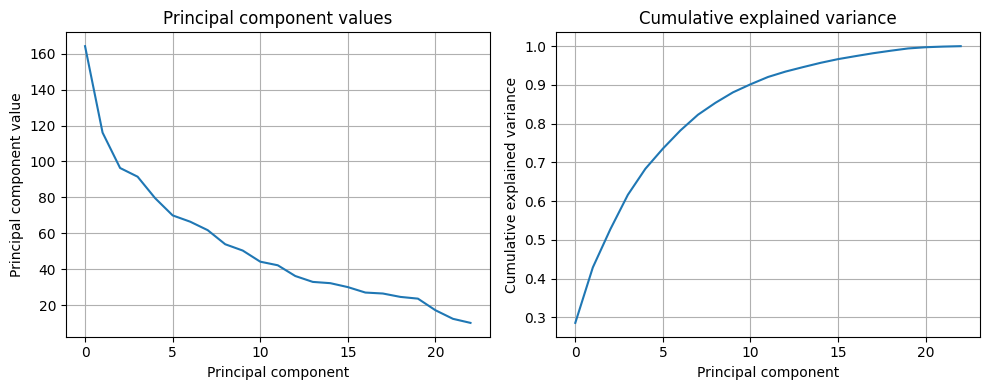

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Principal component values
axs[0].plot(pca.singular_values_)
axs[0].set_title("Principal component values")
axs[0].set_xlabel("Principal component")
axs[0].set_ylabel("Principal component value")
axs[0].grid()

# Cumulative explained variance
axs[1].plot(pca.explained_variance_ratio_.cumsum())
axs[1].set_title("Cumulative explained variance")
axs[1].set_xlabel("Principal component")
axs[1].set_ylabel("Cumulative explained variance")
axs[1].grid()

plt.tight_layout()
plt.savefig(os.path.join(figs_dir, "pca_explained_variance.png"), dpi=300)
plt.show()

### PCA biplots


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


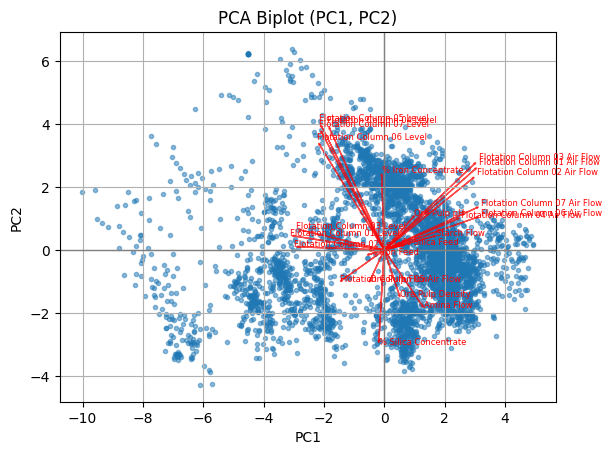

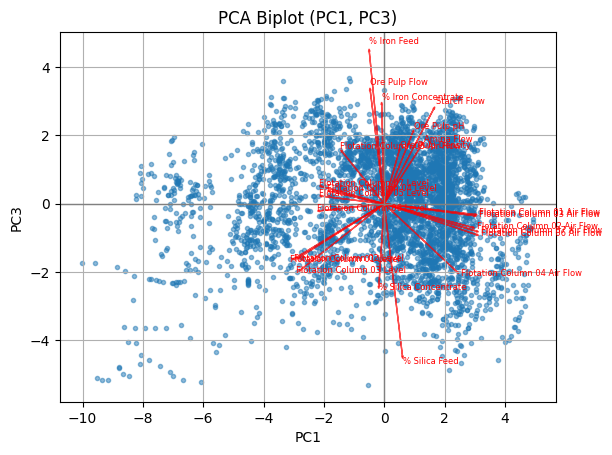

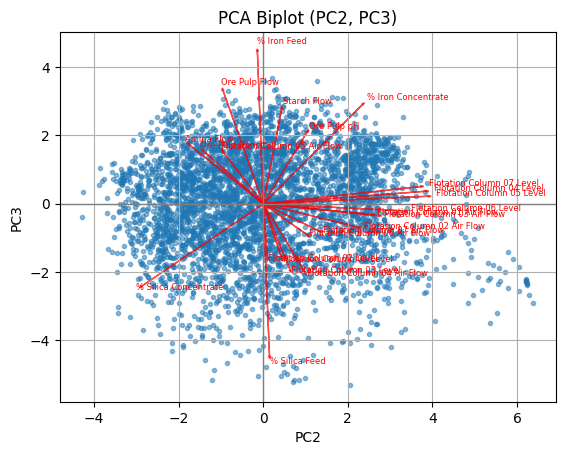

In [ ]:
from itertools import combinations

# Get scores and loadings
scores = pca.transform(PCA_data)
loadings = pca.components_.T

# Scale loadings to match the scale of scores for better visualization
scaled_loadings = loadings * np.max(np.abs(scores))

# Choose the number of principal components to plot
num_components = 3

# Plots for each combination of principal components
for (i, j) in combinations(range(min(num_components, loadings.shape[1])), 2):

    text_locations = []

    # Plot datapoints
    plt.scatter(scores[:, i], scores[:, j], marker='.', alpha=0.5, label="Samples")

    # Plot arrows for loadings
    for k, feature in enumerate(PCA_data.columns):
        u, v = scaled_loadings[k, i], scaled_loadings[k, j]
        plt.arrow(0, 0, u, v, color='r', alpha=0.7, head_width=0.05)
        plt.text(1.05*u, 1.05*v, feature, color='r', fontsize=6)

    # Add reference lines
    plt.axhline(0, color='grey', linewidth=1)
    plt.axvline(0, color='grey', linewidth=1)

    # Labels
    plt.xlabel(f"PC{i+1}")
    plt.ylabel(f"PC{j+1}")
    plt.title(f"PCA Biplot (PC{i+1}, PC{j+1})")
    #plt.legend()
    plt.grid()
    plt.savefig(os.path.join(figs_dir, f"PCA_biplot_PC{i+1}_PC{j+1}.png"), dpi=300)
    plt.show()

---

## Data modeling